### Dependencies

In [1]:
# importing all dependencies

import numpy as np

# for loading image data
# import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models

# for supporting CNN training, testing etc.
from torch import nn
from torch import optim
import torch.nn.functional as F

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Reading and splitting data

In [2]:
# directory address
data_dir = 'mod_database'
# size of batch (might increase later)
batch_size = 8 
# percentage of data for training, validation and testing
train_size, valid_size, test_size = 0.8, 0.1, 0.1


transform = transforms.Compose([transforms.Resize(314), #prev 255
                                transforms.CenterCrop(299), #prev 224
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ])

# reading dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)


# dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

### Transforming and loading images

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

# distributing dataset
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices) # shuffling
split = int(np.floor(train_size * num_data))
split_add = int(np.floor(valid_size * num_data))
# actual splitting
train_idx, valid_idx, test_idx = indices[:split], indices[split: split+split_add], indices[ split+split_add:]
# print(len(train_idx), len(valid_idx), len(test_idx))

# using samplers to get train, valid, and test batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# preparing data loaders (using random sampling)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)



### Visualizing data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape: (8, 3, 299, 299) Batch size: 8
label size: 2


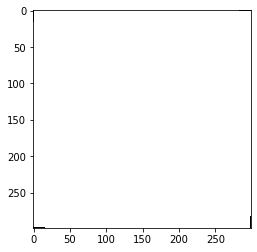

In [4]:
# test of data loader

images, labels = next(iter(train_loader))
images = images.numpy()

print("Shape:", images.shape, "Batch size:", len(images))
plt.imshow(np.transpose(images[0], (1,2,0)))
print("label size:" , labels[0].numpy())

### Downloading the model

In [5]:
model = models.inception_v3(pretrained=True)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [14]:
model = models.densenet121(pretrained=True)
model    

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Freezing params and defining new classification layer

In [6]:
for param in model.parameters():
    param.requires_grad = False
    
fc = nn.Sequential(nn.Linear(2048, 1024), # inceptionv3_out = 2048
# classifier = nn.Sequential(nn.Linear(1024, 512), # densenet121_out = 1024
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512, 2),
                          nn.LogSoftmax(dim=1))

model.fc = fc

### Defining loss and optimizers

In [7]:
criterion = nn.NLLLoss()
# only training classifier params
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transfer model to GPU
model.to(device);
# model.cuda() # if getting cuda "runtime error" try restart the system

### Training and validation

In [8]:
epochs = 30
# steps = 0
train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track changes in validation loss

for e in range(epochs):
    running_loss = 0
    
    for images, labels in train_loader:
#         steps += 1        
#         print(steps)

        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)

        # clearing past gradient values
        optimizer.zero_grad()
        
        logps = model.forward(images)
#         print(logps[0].shape, labels-1)
        loss = criterion(logps[0], labels-1) # 'labels -1' to set 0 index label values
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        
        ############### VALIDATION ##########

    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval() # stop dropout
            for images, labels in valid_loader:
                
                images, labels = images.to(device), labels.to(device)
                labels = labels - 1 # changing to 0 indexed values
                log_ps = model(images)
#                 print(log_ps)
                valid_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(valid_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
        
        # save model if validation loss has decreased
        if valid_losses[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_losses[-1]))
            torch.save(model.state_dict(), 'model_incept.pt')
            valid_loss_min = valid_losses[-1]
        

Epoch: 1/30..  Training Loss: 0.707..  Validation Loss: 0.691..  Validation Accuracy: 0.500
Validation loss decreased (inf --> 0.690692).  Saving model ...
Epoch: 2/30..  Training Loss: 0.687..  Validation Loss: 0.696..  Validation Accuracy: 0.500
Epoch: 3/30..  Training Loss: 0.698..  Validation Loss: 0.700..  Validation Accuracy: 0.500
Epoch: 4/30..  Training Loss: 0.700..  Validation Loss: 0.693..  Validation Accuracy: 0.375
Epoch: 5/30..  Training Loss: 0.678..  Validation Loss: 0.683..  Validation Accuracy: 0.625
Validation loss decreased (0.690692 --> 0.683078).  Saving model ...
Epoch: 6/30..  Training Loss: 0.682..  Validation Loss: 0.680..  Validation Accuracy: 0.750
Validation loss decreased (0.683078 --> 0.680238).  Saving model ...
Epoch: 7/30..  Training Loss: 0.693..  Validation Loss: 0.684..  Validation Accuracy: 0.500
Epoch: 8/30..  Training Loss: 0.683..  Validation Loss: 0.682..  Validation Accuracy: 0.625
Epoch: 9/30..  Training Loss: 0.692..  Validation Loss: 0.683.

### Training and validation loss graph 

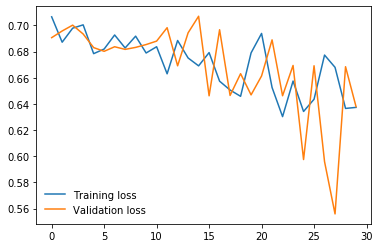

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

### Load the model state with lowest validation

In [10]:
model.load_state_dict(torch.load('model_incept.pt'))

<All keys matched successfully>

In [15]:
img, label = next(iter(test_loader))
# label.shape
len(test_loader)

2

### Test the trained network

In [33]:
# track test loss
cls_len = 2

test_loss = 0.0
accuracy = 0
# class_correct = list(0. for i in range(cls_len))
# class_total = list(0. for i in range(cls_len))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    log_ps = model(data)
    # shifting labels to 0 index
    target -= 1
    # calculate the batch loss
    test_loss += criterion(log_ps, target)
                
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
    
print("Test loss: {:.3f}.. \t Test Accuracy: {:.3f}".format(test_loss/len(test_loader), accuracy/len(test_loader)))

Test loss: 0.619.. 	 Test Accuracy: 0.875
